In [69]:
# setting up all of the packages
!pip install -q optuna

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import torch
import torch.nn as nn
import optuna
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# raster and dataframe handling packages
import rasterio
import rioxarray as rio

# stats packages
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler

# print(os.getcwd())
# custom functions from class LEAP env.
from utils import * 

# plotting parameters
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preparing our predictor and predictand data
predictor: (X, TerraClim climate variables), predictant: (Y, MODIS LAI) data

In [2]:
# establish path and open our merged and masked climate and LAI data as an array
path = "/home/jovyan/large_files/climLai_masked_v3.nc"
ds_combined = xr.open_dataset(path)

In [3]:
# Count NaNs per variable, these should all match!
for var in ds_combined.data_vars:
    print(var, ds_combined[var].isnull().sum().item())

tmmx 598044
tmmn 598044
pr 598044
pdsi 598044
def 598044
vpd 598044
soil 598044
lai 598044


<xarray.Dataset> Size: 77MB
Dimensions:      (time: 228, lat: 71, lon: 74)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 284B -9.825 -9.875 -9.925 ... -13.28 -13.33
  * lon          (lon) float32 296B -72.38 -72.32 -72.28 ... -68.78 -68.72
    spatial_ref  int64 8B ...
Data variables:
    tmmx         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    tmmn         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    pr           (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    pdsi         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    def          (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    vpd          (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    soil         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    lai          (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan


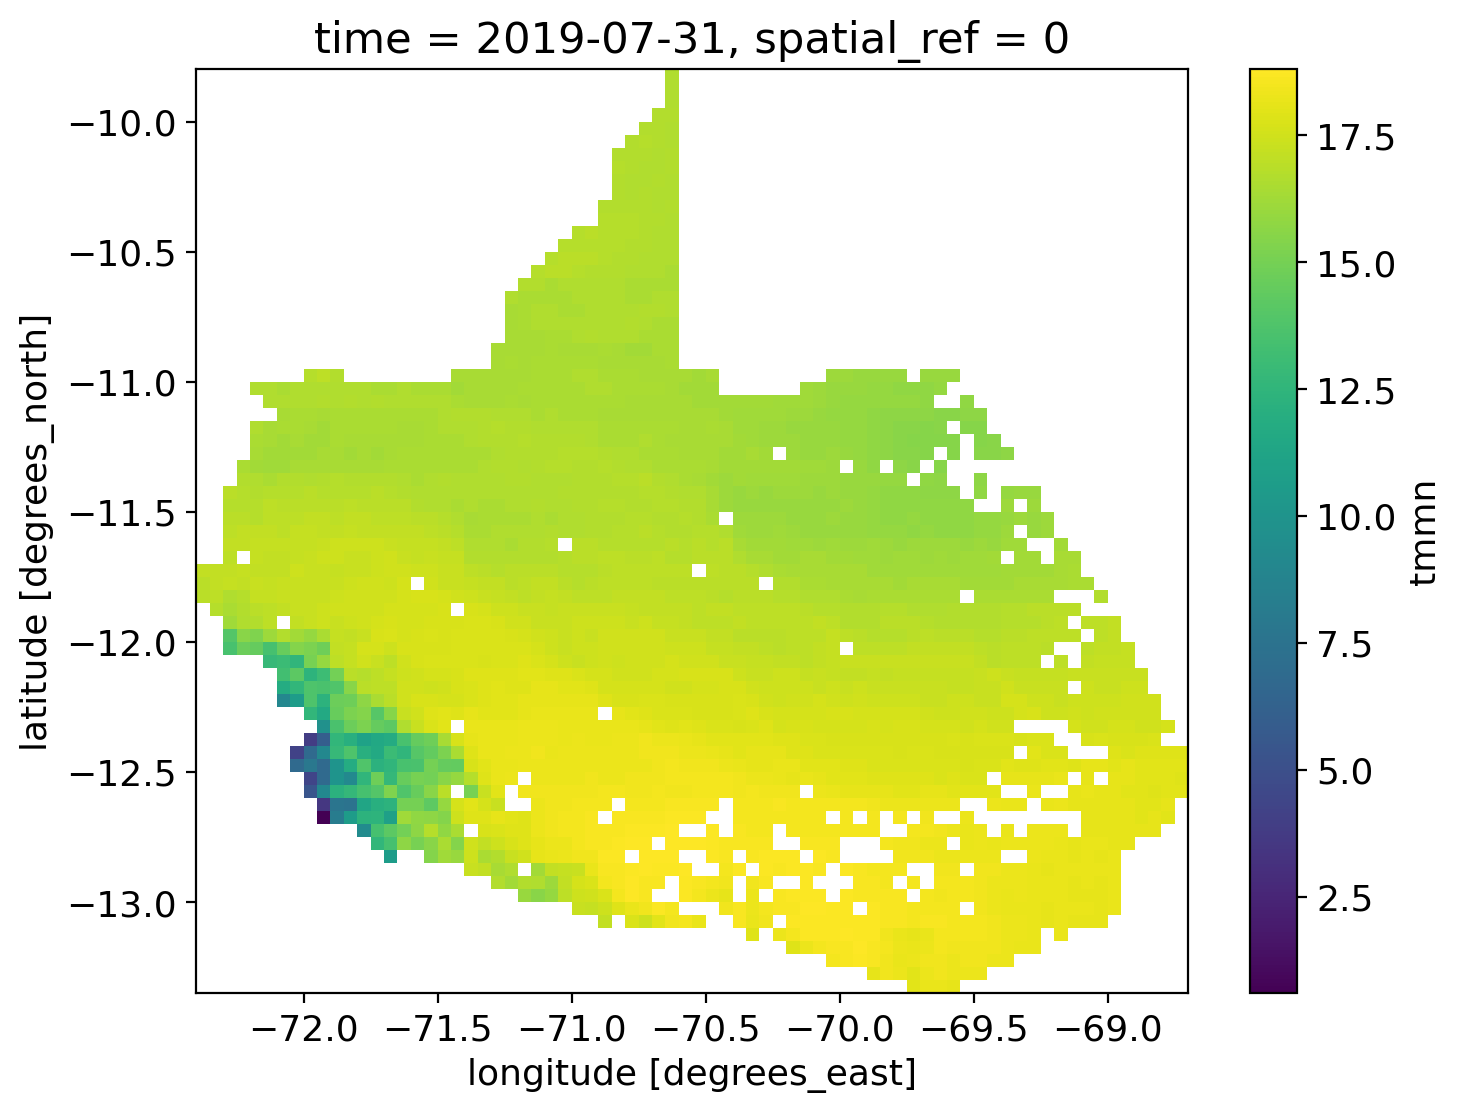

In [4]:
# take a look and map at the ds_combined dataset, this should only cover the political extent of Madre de Dios
print(ds_combined)
ds_combined.tmmn.isel(time=210).plot(figsize=(8,6))

In [5]:
# the data array has 3 dimensions (time, lat, lon). Stack the coordinate values to go from 3d to 2d.
ds_stacked = ds_combined.stack(stacked=("lat", "lon"))

In [6]:
# convert to data frame for later processing. Time, lat, lon become indexes.
df_combined = ds_stacked.to_dataframe().dropna()
print(df_combined)

                                  tmmx  tmmn     pr  pdsi  def   vpd   soil  \
time       lat        lon                                                     
2002-01-31 -9.825002  -70.625000  31.0  21.3  396.0  7.37  0.0  0.74  204.6   
           -9.875002  -70.625000  31.0  21.4  386.0  7.36  0.0  0.75  203.9   
           -9.925001  -70.625000  31.1  21.4  382.0  7.36  0.0  0.76  203.5   
           -9.975001  -70.674995  31.1  21.5  374.0  7.13  0.0  0.77  199.3   
                      -70.625000  31.1  21.4  377.0  7.33  0.0  0.77  203.1   
...                                ...   ...    ...   ...  ...   ...    ...   
2020-12-31 -13.275002 -69.474998  30.8  22.1  516.0 -3.21  0.0  0.90  208.0   
           -13.325002 -69.724998  30.3  21.6  585.0 -1.99  0.0  0.89  171.8   
                      -69.674995  30.5  21.8  572.0 -2.02  0.0  0.90  177.6   
                      -69.625000  30.5  22.0  551.0 -2.44  0.0  0.90  189.1   
                      -69.574997  30.5  21.8  543.0 

In [7]:
# from dataframe generate the x_df (ONLY climate predictor variables, drop the lai column)
x_df = df_combined.drop(columns=["lai","spatial_ref"])

# look at x_df, make sure it looks ok!
x_df.head()

tmmx  tmmn     pr  pdsi  def   vpd   soil
time       lat       lon                                                  
2002-01-31 -9.825002 -70.625000  31.0  21.3  396.0  7.37  0.0  0.74  204.6
           -9.875002 -70.625000  31.0  21.4  386.0  7.36  0.0  0.75  203.9
           -9.925001 -70.625000  31.1  21.4  382.0  7.36  0.0  0.76  203.5
           -9.975001 -70.674995  31.1  21.5  374.0  7.13  0.0  0.77  199.3
                     -70.625000  31.1  21.4  377.0  7.33  0.0  0.77  203.1

In [8]:
# from dataframe generate y_df (ONLY lai)
y_df = df_combined.drop(columns=["spatial_ref",
                                 "tmmx",
                                 "tmmn",
                                 "pr",
                                 "pdsi",
                                 "def",
                                 "vpd",
                                 "soil"])

# look at y_df, make sure it looks ok!
y_df.head()

lai
time       lat       lon                 
2002-01-31 -9.825002 -70.625000  5.988894
           -9.875002 -70.625000  5.596181
           -9.925001 -70.625000  5.571186
           -9.975001 -70.674995  5.901039
                     -70.625000  5.268743

## Split our data into training, validation and testing and normalize
Look at the entire time sequence of our data: 19 years, 12 months per year
(19yrs x 12months) = 228 time steps

We want the last two years to be our testing dataset: 2019 and 2020
Therefore, the first 17 tears are our training and validation data
Of this, 80% must be training (14 years), 20% must be validation (3 years)

So the final break-down is:
Training: 2002-2015 (14yrs x 12months = 168 ts)
Validation: 2016-2018 (3yrs x 12months = 36 ts)
Testing: 2019-2020 (2yrs x 12months = 24 ts)

In [9]:
# look at the entire time sequence of our data
first_time = x_df.index.get_level_values("time")[0]
last_time  = x_df.index.get_level_values("time")[-1]

print('time 0 =', first_time)
print('time last =', last_time)

time 0 = 2002-01-31 00:00:00
time last = 2020-12-31 00:00:00


In [10]:
# splitting the data according to the time splits above

# establish the before and after for the testing set
#times = x_df.index.get_level_values("time")
#mask_before_testing = times < '2014-01-31 00:00:00' # everything before 2014 is training-val
#mask_after_testing  = times >= '2014-01-31 00:00:00' # everything after 2014 is testing

# split the data into training + validation and testing
#x_df_trainval = x_df.loc[mask_before_testing]
#x_df_test_all = x_df.loc[mask_after_testing]
#y_df_trainval = y_df.loc[mask_before_testing]
#y_df_test_all = y_df.loc[mask_after_testing]

# in the testing data, limit to only 2014 data
#times_testing = x_df_test_all.index.get_level_values("time")
#mask_before_2015 = times_testing < '2015-01-31 00:00:00' # everything before 2015 that has not been assigned to trainval is testing

#x_df_test = x_df_test_all.loc[mask_before_2015]
#y_df_test = y_df_test_all.loc[mask_before_2015]

# split the training and validation data
#mask_before_trainval = times < '2012-01-31 00:00:00'
#mask_after_trainval = times >= '2012-01-31 00:00:00'

# split trainval into training and validation data
#x_df_train_02 = x_df.loc[mask_before_trainval]
#x_df_valid_all = x_df.loc[mask_after_trainval]
#y_df_train_02 = y_df.loc[mask_before_trainval]
#y_df_valid_all = y_df.loc[mask_after_trainval]

# in the training data, get rid of 2002 <-- 2002 is an odd year, data wise, introducing a lot of noise
#times_training = x_df_train_02.index.get_level_values("time")
#mask_after_2002 = times_training >= '2003-01-31 00:00:00'

# in the validation data, get rid of everything post 2014
#times_valid = x_df_valid_all.index.get_level_values("time")
#mask_before_2014 = times_valid < '2015-01-31 00:00:00'

#x_df_train = x_df_train_02.loc[mask_after_2002]
#y_df_train = y_df_train_02.loc[mask_after_2002]

#x_df_valid = x_df_valid_all.loc[mask_before_2014]
#y_df_valid = y_df_valid_all.loc[mask_before_2014]

In [11]:
# splitting data into training/validation and testing

# establish the before and after for the testing set
times = x_df.index.get_level_values("time")
mask_before_testing = times < '2014-01-31 00:00:00' # everything before 2014 is training-val
mask_after_testing  = times >= '2014-01-31 00:00:00' # everything after 2014 is testing

# split the data into training + validation and testing
x_df_trainval = x_df.loc[mask_before_testing]
x_df_test_all = x_df.loc[mask_after_testing]
y_df_trainval = y_df.loc[mask_before_testing]
y_df_test_all = y_df.loc[mask_after_testing]

# in the testing data, limit to only 2014 data
times_testing = x_df_test_all.index.get_level_values("time")
mask_before_2015 = times_testing < '2015-01-31 00:00:00' # everything before 2015 that has not been assigned to trainval is testing

x_df_test = x_df_test_all.loc[mask_before_2015]
y_df_test = y_df_test_all.loc[mask_before_2015]

In [12]:
# standardize our training/validation and testing data
# get mean and std values from the training data
mean, std = x_df_trainval.mean(), x_df_trainval.std()

# normalize
x_df_trainval = (x_df_trainval - mean)/std
x_df_test = (x_df_test - mean)/std

print(x_df_trainval)

                                      tmmx      tmmn        pr      pdsi  \
time       lat        lon                                                  
2002-01-31 -9.825002  -70.625000  0.752068  0.979544  1.145636  2.521592   
           -9.875002  -70.625000  0.752068  1.029709  1.084552  2.518400   
           -9.925001  -70.625000  0.825361  1.029709  1.060119  2.518400   
           -9.975001  -70.674995  0.825361  1.079874  1.011252  2.444989   
                      -70.625000  0.825361  1.029709  1.029577  2.508824   
...                                    ...       ...       ...       ...   
2013-12-31 -13.275002 -69.474998 -0.274034  1.180204  1.341103  0.772506   
           -13.325002 -69.724998 -0.713792  0.879214  1.903071  0.727822   
                      -69.674995 -0.567206  0.979544  1.799229  0.734205   
                      -69.625000 -0.493913  1.079874  1.622087  0.756548   
                      -69.574997 -0.567206  0.979544  1.548787  0.766123   

           

In [13]:
feature_cols = ["tmmx","tmmn","pr","pdsi","def","vpd","soil"]

# let's check the normalizaton
# look at some summary statistics to check the normalization
trainval_stats = x_df_trainval[feature_cols].agg(['mean','std']).T
test_stats = x_df_test[feature_cols].agg(['mean','std']).T

# let's check our standardization
print("Training data\n", trainval_stats)
print("Testing data\n", test_stats)

Training data
               mean  std
tmmx -1.248303e-16  1.0
tmmn  1.157081e-15  1.0
pr   -3.840934e-17  1.0
pdsi  1.440350e-17  1.0
def  -9.122218e-17  1.0
vpd  -7.345786e-16  1.0
soil  1.752426e-16  1.0
Testing data
           mean       std
tmmx  0.020549  1.060268
tmmn  0.230373  0.924187
pr   -0.093680  0.907933
pdsi  0.253799  0.617260
def   0.093909  0.936438
vpd   0.204322  1.336508
soil -0.055907  1.030178


In [14]:
# split the training and validation data, now that it has been normalized

# split the training and validation data
times_trainval = x_df_trainval.index.get_level_values("time")
mask_before_trainval = times_trainval < '2012-01-31 00:00:00'
mask_after_trainval = times_trainval >= '2012-01-31 00:00:00'

# split trainval into training and validation data
x_df_train_02 = x_df_trainval.loc[mask_before_trainval]
x_df_valid_all = x_df_trainval.loc[mask_after_trainval]
y_df_train_02 = y_df_trainval.loc[mask_before_trainval]
y_df_valid_all = y_df_trainval.loc[mask_after_trainval]

# in the training data, get rid of 2002 <-- 2002 is an odd year, data wise, introducing a lot of noise
times_training = x_df_train_02.index.get_level_values("time")
mask_after_2002 = times_training >= '2003-01-31 00:00:00'

# in the validation data, get rid of everything post 2014
times_valid = x_df_valid_all.index.get_level_values("time")
mask_before_2014 = times_valid < '2015-01-31 00:00:00'

x_df_train = x_df_train_02.loc[mask_after_2002]
y_df_train = y_df_train_02.loc[mask_after_2002]

x_df_valid = x_df_valid_all.loc[mask_before_2014]
y_df_valid = y_df_valid_all.loc[mask_before_2014]

In [15]:
# check the data splits
# look at the entire time sequence of our data
first_time_train = x_df_train.index.get_level_values("time")[0]
last_time_train  = x_df_train.index.get_level_values("time")[-1]

print('time 0 of training =', first_time_train)
print('time last of training =', last_time_train)

first_time_valid = x_df_valid.index.get_level_values("time")[0]
last_time_valid  = x_df_valid.index.get_level_values("time")[-1]

print('time 0 of validation =', first_time_valid)
print('time last of validation =', last_time_valid)

time 0 of training = 2003-01-31 00:00:00
time last of training = 2011-12-31 00:00:00
time 0 of validation = 2012-01-31 00:00:00
time last of validation = 2013-12-31 00:00:00


In [16]:
# test to make sure the splits worked:
print('shape x_df_train', x_df_train.shape)
print('shape x_df_valid', x_df_valid.shape)
print('shape x_df_test', x_df_test_all.shape)

print('shape y_df_train', y_df_train.shape)
print('shape y_df_valid', y_df_valid.shape)
print('shape y_df_test', y_df_test_all.shape)

shape x_df_train (284148, 7)
shape x_df_valid (63144, 7)
shape x_df_test (221004, 7)
shape y_df_train (284148, 1)
shape y_df_valid (63144, 1)
shape y_df_test (221004, 1)


In [17]:
# look at some summary statistics to check the normalization
train_stats = x_df_train[feature_cols].agg(['mean','std']).T
valid_stats = x_df_valid[feature_cols].agg(['mean','std']).T
test_stats = x_df_test[feature_cols].agg(['mean','std']).T

# let's check our standardization
print("Training data\n", train_stats)
print("Validation data\n", valid_stats)
print("Testing data\n", test_stats)

Training data
           mean       std
tmmx -0.000161  0.992465
tmmn -0.017405  1.008845
pr   -0.026596  0.988415
pdsi -0.135165  0.987227
def   0.037047  1.048382
vpd   0.015789  0.986408
soil -0.029522  1.005395
Validation data
           mean       std
tmmx  0.018638  0.991734
tmmn  0.068840  0.968941
pr   -0.049334  0.843268
pdsi -0.095140  0.527759
def  -0.161871  0.773527
vpd  -0.070197  1.069920
soil  0.119741  0.963383
Testing data
           mean       std
tmmx  0.020549  1.060268
tmmn  0.230373  0.924187
pr   -0.093680  0.907933
pdsi  0.253799  0.617260
def   0.093909  0.936438
vpd   0.204322  1.336508
soil -0.055907  1.030178


## Reshape data to feed into the LSTM model
0) Make time a column (not index) in our data
1) Merge predictors and predictands
2) Scale the climate inputs.
   Training data will be normalized to mean=0, std=1, Validation data will be scaled with those meands and std
3) Create the look-back window per pixel!
4) Convert to PyTorch datasets
5) Create the Data Loaders, shuffle=False

In [18]:
# 0 - Ensure Time is a column of our data
# Time is currently an INDEX not a column of our data, we need to convert it into a COLUMN
def ensure_time_column(df):
    if "time" not in df.columns:
        # index must be time
        df = df.reset_index().rename(columns={"index": "time"})
    df["time"] = pd.to_datetime(df["time"])
    return df

In [19]:
# 1 - Merge the X (predictors, climate variables) and Y (predictands, modis lai) datasets
def merge_xy(x_df, y_df):
    x_df = ensure_time_column(x_df)
    y_df = ensure_time_column(y_df)
    
    df = x_df.merge(y_df, on=["time", "lat", "lon"], how="inner")
    df = df.sort_values(["lat", "lon", "time"]).reset_index(drop=True)
    return df

train_df = merge_xy(x_df_train, y_df_train)
valid_df = merge_xy(x_df_valid, y_df_valid)
# adding the test data to this nonsense
test_df = merge_xy(x_df_test, y_df_test)

In [20]:
# 2 - scale the climate inputs
# find the mean and std of each feature in the training dataset and standardize to mean=0, std=1
# then use the mean and std of the TRAINING data to scale the validation data
#feature_cols = ["tmmx", "tmmn", "pr", "pdsi", "def", "vpd", "soil"] # define the feature columns to scale

#scaler = StandardScaler()
#train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols]) # TRAINING DATA, CALL THE FIT_TRANSFORM
#valid_df[feature_cols] = scaler.transform(valid_df[feature_cols]) # VALIDATION DATA, CALL THE TRANSFORM
#test_df[feature_cols] = scaler.transform(test_df[feature_cols]) # TESTING DATA, CALL THE TRANSFORM

# let's check our standardization
#train_stats = train_df[feature_cols].agg(['mean','std']).T
#valid_stats = valid_df[feature_cols].agg(['mean','std']).T
#test_stats = test_df[feature_cols].agg(['mean','std']).T
#print("TRAIN\n", train_stats)
#print("VALID\n", valid_stats)

# TRAINING: Mean of Training data should be very close to 0, and sdt roughly 1
# VALID: Validation data should NOT have the same mean and std values, but it should be scaled to the training data, different values same scale

In [56]:
# 3 - build the lstm sequences for each pixel, establish 3 timesteps (months) as our "look-back" window
# define sequence building function
def build_sequences(df, feature_cols, lookback):
    X_list, y_list, coords = [], [], []

    # for every lat, lon combination in grouping by lat,lon (pixel)
    for (lat, lon), group in df.groupby(["lat", "lon"]):
        group = group.sort_values("time") #sort by values of time, each time instance is 1 month

        X_vals = group[feature_cols].values #for x, get values of predictors (defined by all feature cols)
        y_vals = group["lai"].values #for y, get values of lai, predictant

        # for every instance in the length of the entire time sequence minus the lookback window
        for i in range(len(group) - lookback): 
            # the instances in lookback window predict 1 timestep after lookback window, last three months predict the fourth, etc.
            X_list.append(X_vals[i:i+lookback]) # append all the x values in index of instance start to end of instance (length of window)
            y_list.append(y_vals[i+lookback]) # append value that is in place of start of instance + length of lookback window
            coords.append((lat, lon))

    return (
        np.array(X_list, dtype=np.float32),
        np.array(y_list, dtype=np.float32),
        coords,
    )

lookback = 22 # will use the past 6 months (time-steps of data) to get the next 7th month

# apply the function
X_train_np, y_train_np, train_coords = build_sequences(train_df, feature_cols, lookback)
X_valid_np, y_valid_np, valid_coords = build_sequences(valid_df, feature_cols, lookback)
X_test_np, y_test_np, test_coords = build_sequences(valid_df, feature_cols, lookback)

print("Train X shape:", X_train_np.shape) # (len_t), lookback, feat
print("Valid X shape:", X_valid_np.shape) # (len_v), lookback, feat

# Train X shape and Valid X shape should have the same lookback and features (the last two values)
# BUT should differ in their first dimension, with Train beging larger reflecting there is a greater ammount of data going into training

Train X shape: (226266, 22, 7)
Valid X shape: (5262, 22, 7)


In [57]:
# 4 - convert to PYTORCH dataset, ready for model ingestion

# before conversion, check for NaNs again. Model will not work if NaNs are present.
np.isnan(X_valid_np).any(), np.isnan(y_valid_np).any(), np.isnan(X_test_np).any()

# define the pytorch conversion function
class ClimateLAIDataset(Dataset):
    def __init__(self, X, y, coords):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.coords = coords

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ClimateLAIDataset(X_train_np, y_train_np, train_coords)
valid_dataset = ClimateLAIDataset(X_valid_np, y_valid_np, valid_coords)
test_dataset = ClimateLAIDataset(X_test_np, y_test_np, test_coords)


In [58]:
# 5 - DATALOADERS, both should be shuffle=false because this is time series data! we want the chronological order
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Define LSTM structure
1) set the model hyperparameters
2) define the model
3) define optimizer (ADAM) and evaluation criteria (MSE of loss)

In [59]:
# CHANGED

# 1 - set hyperparameters
n_neuron       = 64
num_layers     = 1
activation     = 'ReLU'
num_epochs     = 30
learning_rate  = 0.00001
minibatch_size = 64 #CHECK
model_num      = 1

In [60]:
# CHANGED

# 2 - define the model

# device definition, make sure model is running on GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model definition
import torch.nn as nn

# class LAI_LSTM(nn.Module):
#     def __init__(self, num_features=7, hidden_size=64, num_layers=1):
#         super(LAI_LSTM, self).__init__()

#         self.lstm = nn.LSTM(
#             input_size=num_features,
#             hidden_size=hidden_size,
#             num_layers=num_layers,
#             batch_first=True
#         )
#         self.fc = nn.Linear(hidden_size, 1)

#     def forward(self, x):

#         # Run LSTM
#         output, (h_n, c_n) = self.lstm(x)
#         # Fully connected layer on last hidden state
#         out = self.fc(h_n[-1])

#         # Squeeze last dimension only
#         out = out.squeeze(1)

#         return out

class InputAttention(nn.Module):
    """
    Feature-level attention (which input variables matter at each timestep)
    """
    def __init__(self, input_dim, hidden_dim):
        super(InputAttention, self).__init__()
        self.attn = nn.Linear(hidden_dim + input_dim, input_dim)

    def forward(self, x_t, h_prev):
        # x_t: [batch, input_dim]
        # h_prev: [batch, hidden_dim]

        combined = torch.cat((x_t, h_prev), dim=1)
        scores = self.attn(combined)                   # [batch, input_dim]
        weights = F.softmax(scores, dim=1)             # feature-level attention
        x_tilde = weights * x_t                        # element-wise weighting

        return x_tilde, weights


class TemporalAttention(nn.Module):
    """
    Time-step attention (which timesteps matter most)
    """
    def __init__(self, hidden_dim):
        super(TemporalAttention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, encoder_outputs):
        # encoder_outputs: [batch, seq_len, hidden_dim]

        scores = self.attn(encoder_outputs)            # [batch, seq_len, 1]
        weights = F.softmax(scores, dim=1)             # time-level attention
        context = torch.sum(weights * encoder_outputs, dim=1)

        return context, weights


class DA_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super(DA_RNN, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM cell for stepwise encoding
        self.encoder_lstm = nn.LSTMCell(input_dim, hidden_dim)

        # Attention blocks
        self.input_attention = InputAttention(input_dim, hidden_dim)
        self.temporal_attention = TemporalAttention(hidden_dim)

        # Output layer
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        batch_size, seq_len, input_dim = x.size()

        h_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)

        encoder_outputs = []

        # ----- Encoder with feature-level attention -----
        for t in range(seq_len):
            x_t = x[:, t, :]                                  # [batch, input_dim]

            # Feature-level attention
            x_tilde, feature_weights = self.input_attention(x_t, h_t)

            # LSTM step
            h_t, c_t = self.encoder_lstm(x_tilde, (h_t, c_t))

            encoder_outputs.append(h_t.unsqueeze(1))

        encoder_outputs = torch.cat(encoder_outputs, dim=1)   # [batch, seq_len, hidden_dim]

        # ----- Temporal (time-level) attention -----
        context, time_weights = self.temporal_attention(encoder_outputs)

        # ----- Final prediction -----
        out = self.fc(context)                                # [batch, 1]
        out = out.squeeze(1)

        return out, feature_weights, time_weights

model = DA_RNN(input_dim=7, 
               hidden_dim=n_neuron, 
               num_layers=num_layers)
model.to(device)
print("DA-RNN ready ✅")

DA-RNN ready ✅


In [61]:
# CHANGED

# 3 - define the optimizer (ADAM), and the evaluation criterion: MSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

## Training and saving the model

In [62]:
# CHANGED

from utils import pytorch_train2
train_losses_mse, val_losses_mse = pytorch_train2(model, optimizer, criterion = criterion, 
                                                 device = device, 
                                                 train_loader = train_loader, val_loader = val_loader, 
                                                   num_epochs = num_epochs)

Epoch 1/30, Train Loss: 8.3356, Val Loss: 0.6205
Epoch 2/30, Train Loss: 0.5385, Val Loss: 0.6218
Epoch 3/30, Train Loss: 0.4458, Val Loss: 0.3672
Epoch 4/30, Train Loss: 0.3837, Val Loss: 0.3659
Epoch 5/30, Train Loss: 0.3556, Val Loss: 0.4035
Epoch 6/30, Train Loss: 0.3368, Val Loss: 0.4655
Epoch 7/30, Train Loss: 0.3198, Val Loss: 0.5295
Epoch 8/30, Train Loss: 0.3062, Val Loss: 0.5710
Epoch 9/30, Train Loss: 0.2978, Val Loss: 0.5825
Epoch 10/30, Train Loss: 0.2920, Val Loss: 0.5805
Epoch 11/30, Train Loss: 0.2875, Val Loss: 0.5741
Epoch 12/30, Train Loss: 0.2837, Val Loss: 0.5659
Epoch 13/30, Train Loss: 0.2803, Val Loss: 0.5568
Epoch 14/30, Train Loss: 0.2771, Val Loss: 0.5468
Epoch 15/30, Train Loss: 0.2742, Val Loss: 0.5359
Epoch 16/30, Train Loss: 0.2714, Val Loss: 0.5237
Epoch 17/30, Train Loss: 0.2687, Val Loss: 0.5101
Epoch 18/30, Train Loss: 0.2659, Val Loss: 0.4947
Epoch 19/30, Train Loss: 0.2631, Val Loss: 0.4765
Epoch 20/30, Train Loss: 0.2600, Val Loss: 0.4544
Epoch 21/

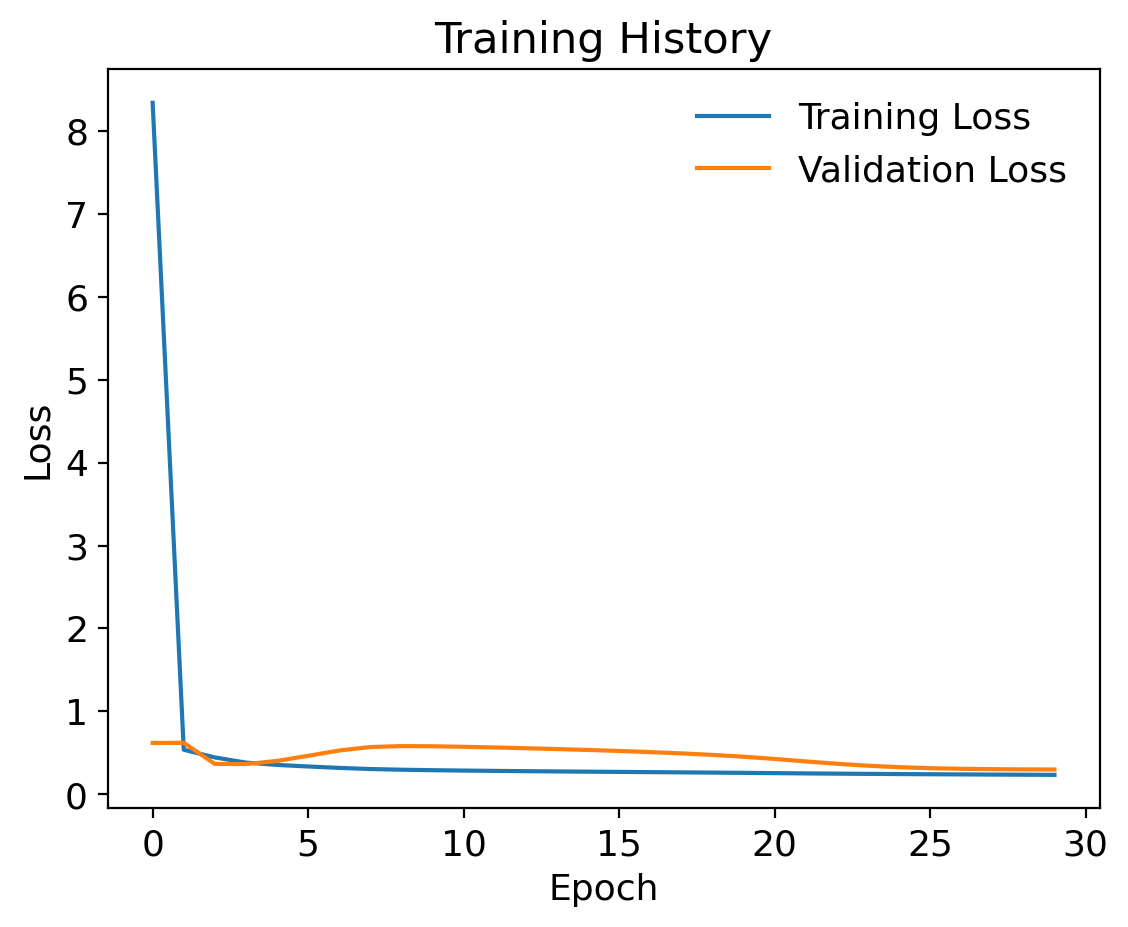

In [63]:
# looking at our training and validation loss
plot_history(train_losses_mse, val_losses_mse)

In [71]:
# CHANGED

# export and SAVE model
model_path = '/home/jovyan/large_files/model_outputs/v6/'
make_dir(model_path)

# Save the model weights to a pth file.
torch.save(model.state_dict(), os.path.join(model_path,'attn_lkb22.pth'))

print(model)

DA_RNN(
  (encoder_lstm): LSTMCell(7, 64)
  (input_attention): InputAttention(
    (attn): Linear(in_features=71, out_features=7, bias=True)
  )
  (temporal_attention): TemporalAttention(
    (attn): Linear(in_features=64, out_features=1, bias=True)
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## Variable Importances 

In [65]:
# CHANGED

model.eval()

all_feature_attn = []
all_time_attn = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)

        _, feature_attn, time_attn = model(batch_X)

        all_feature_attn.append(feature_attn.cpu())
        all_time_attn.append(time_attn.cpu())

# Stack and average
all_feature_attn = torch.cat(all_feature_attn, dim=0)
all_time_attn = torch.cat(all_time_attn, dim=0)

var_importance = all_feature_attn.mean(dim=0)
time_importance = all_time_attn.squeeze(-1).mean(dim=0)


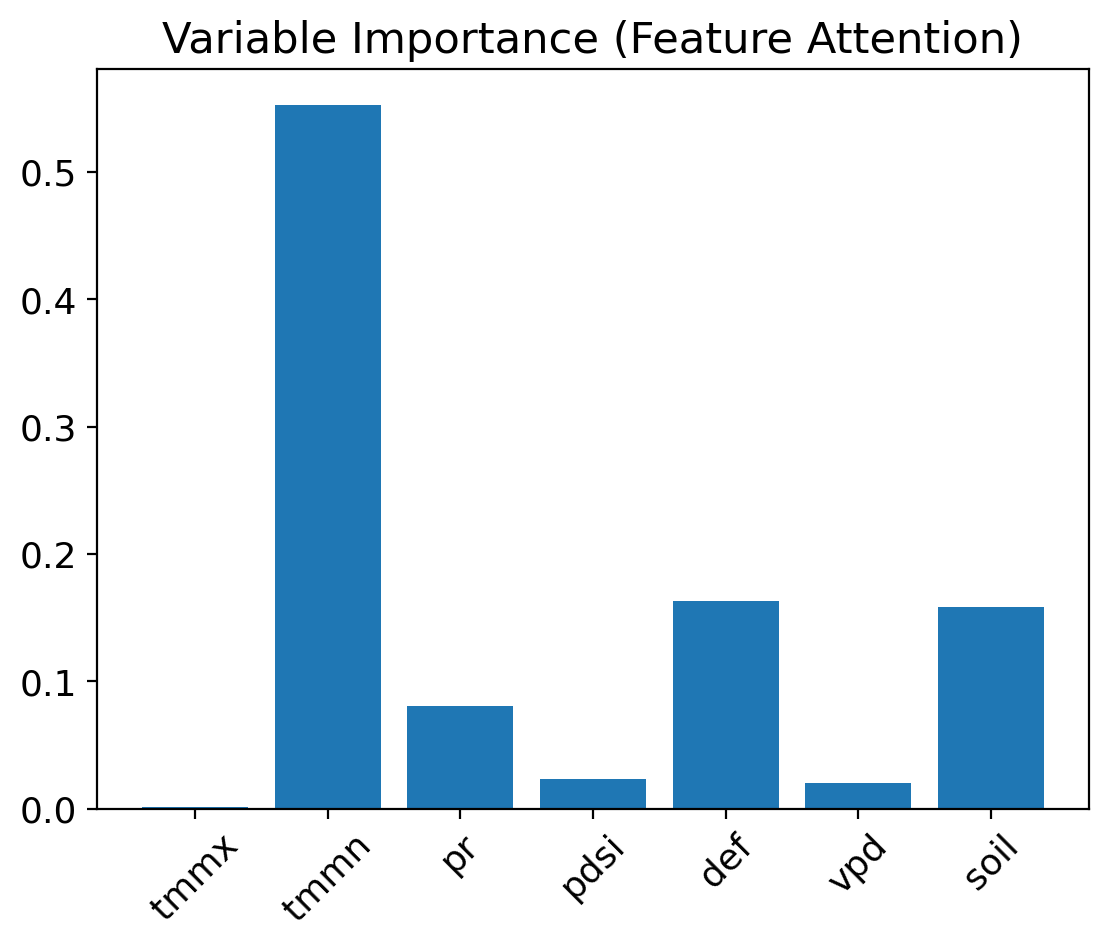

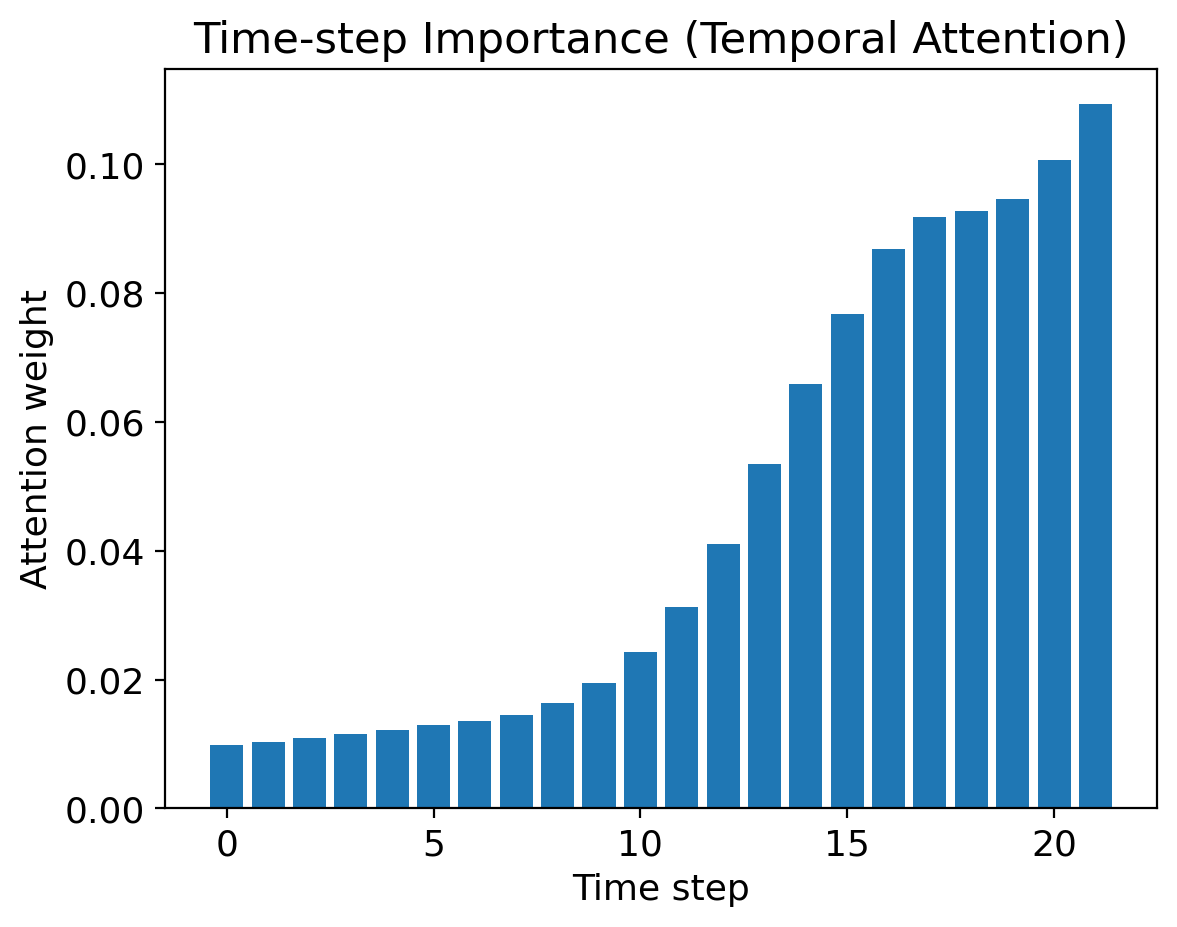

In [66]:
# CHANGED

var_imp_np = var_importance.numpy()
time_imp_np = time_importance.numpy()

feature_names = ["tmmx","tmmn","pr","pdsi","def","vpd","soil"]

plt.bar(feature_names, var_imp_np)
plt.xticks(rotation=45)
plt.title("Variable Importance (Feature Attention)")
plt.show()

plt.bar(range(len(time_imp_np)), time_imp_np)
plt.title("Time-step Importance (Temporal Attention)")
plt.xlabel("Time step")
plt.ylabel("Attention weight")
plt.show()

## Testing the Model

In [70]:
# make new model instances
model_eval = DA_RNN(input_dim=7, hidden_dim=64, num_layers=1)

# reload the saved model weights
state_dict = torch.load('/home/jovyan/large_files/model_outputs/v6/attn_lkb22.pth', weights_only=True)
model_eval.load_state_dict(state_dict)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/large_files/model_outputs/v6/attn_lkb22.pth'

In [65]:
# run model

model_eval.to(device).eval()
preds_list = []
targs_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:   # training loop unchanged
        X_batch = X_batch.to(device)
        outputs, feature_attn, time_attn = model(batch_X)
        preds_list.append(outputs)
        targs_list.append(y_batch.numpy())

preds = np.concatenate(preds_list, axis=0)
targets = np.concatenate(targs_list, axis=0)

# Get coords from the dataset (must be in same order as samples)
coords = np.array(test_dataset.coords)   # shape (N_samples, 2) or similar

assert len(preds) == len(coords), "Order mismatch: ensure test_loader shuffle=False and drop_last=False"


AssertionError: Order mismatch: ensure test_loader shuffle=False and drop_last=False

In [ ]:
# compute the rmse per pixel and return a df of values INDEXED exactly as the input data
def compute_rmse_per_pixel(coords, preds, targets):
    df = pd.DataFrame({
        "lat": coords[:, 0],
        "lon": coords[:, 1],
        "pred": preds,
        "true": targets
    })

    def rmse(x, y):
        return np.sqrt(np.mean((x - y)**2))

    rmse_df = df.groupby(["lat", "lon"]).apply(
        lambda g: rmse(g["pred"], g["true"])
    ).reset_index(name="rmse")

    return rmse_df

In [ ]:
# take a look at this!
rmse_df = compute_rmse_per_pixel(coords, preds, targets)
print(rmse_df.head())

In [78]:
# save the rmse calculations to a raster
def rmse_to_raster(rmse_df):
    lats = np.sort(rmse_df["lat"].unique())
    lons = np.sort(rmse_df["lon"].unique())

    # Initialize raster
    raster = np.full((len(lats), len(lons)), np.nan, dtype=float)

    # Fill raster per coordinate
    for _, row in rmse_df.iterrows():
        lat_idx = np.where(lats == row["lat"])[0][0]
        lon_idx = np.where(lons == row["lon"])[0][0]
        raster[lat_idx, lon_idx] = row["rmse"]

    return raster, lats, lons

In [79]:
# run raster saving function from above
rmse_raster, lats, lons = rmse_to_raster(rmse_df)
rmse_raster = np.flipud(rmse_raster)
lats = lats[::-1]
print(rmse_raster.shape)

(71, 74)


In [81]:
# save your rmse raster to a geotiff
import rasterio
from rasterio.transform import from_origin

def save_rmse_geotiff(filename, raster, lats, lons):
    # Compute resolution
    lat_res = abs(lats[1] - lats[0])
    lon_res = abs(lons[1] - lons[0])
    
    transform = from_origin(min(lons), max(lats), lon_res, lat_res)

    with rasterio.open(
        filename,
        "w",
        driver="GTiff",
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs="EPSG:4326",
        transform=transform,
    ) as dst:
        dst.write(raster, 1)

In [82]:
# run and save! name your save with the length of the looback window
save_rmse_geotiff("/home/jovyan/models/lai_rmse_map_lb3mo.tif", rmse_raster, lats, lons)

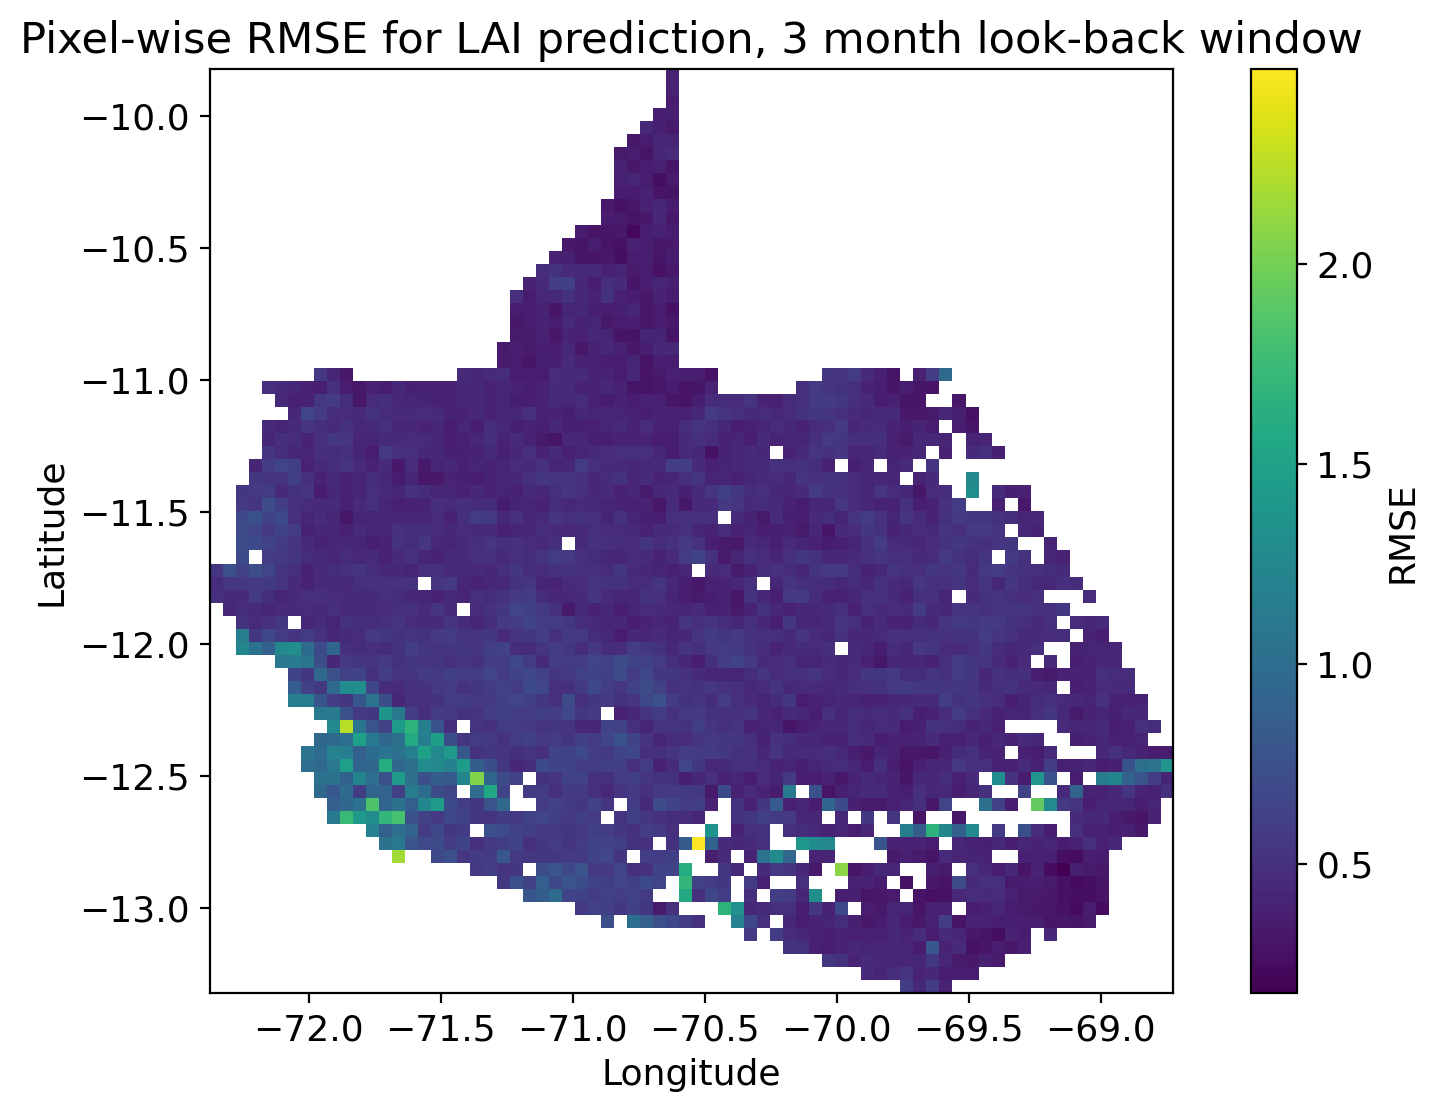

In [84]:
# plot your rmse raster
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.imshow(rmse_raster, cmap="viridis", origin="upper",
           extent=[min(lons), max(lons), min(lats), max(lats)])
plt.colorbar(label="RMSE")
plt.title("Pixel-wise RMSE for LAI prediction, 3 month look-back window")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()